In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
import pandas as pd
import numpy as np
np.random.seed(42)
PATH = '/Users/orendar/Downloads/dataverse_files/'

In [2]:
train_df = pd.read_csv(f'{PATH}train_raw.csv', index_col = 0)
test_df = pd.read_csv(f'{PATH}test_raw.csv',  index_col = 0)

In [3]:
train_df.head().T

,1,2,3,4,5
year,2002,2002,2002,2002,2002
camp.length,23,23,23,23,23
deminc,1,1,1,1,1
base.poll,45.7447,45.7447,45.7447,45.7447,45.7447
base.und,6,6,6,6,6
office,0,0,0,0,0
d.gone.neg,0,0,1,1,1
d.gone.neg.l1,0,0,1,1,1
d.gone.neg.l2,0,0,0,1,1
d.neg.frac.l3,0,0,0,0,0.0714286


In [4]:
cat_features = ["deminc", "d.gone.neg.l1", "d.gone.neg.l2", "year",
                "office", "camp.length", "base.und"]

cont_features = ["r.neg.frac.l2", "r.neg.frac.l3", "rep.contrib.l1", 
                 "rep.contrib.l2", "dem.contrib.l1", "dem.contrib.l2", "num.rep.l1",
                 "num.rep.l2", "num.dem.l1", "num.dem.l2", "d.neg.frac.l3", "undother.l2",
                 "undother.l1", "dem.polls.l1", "dem.polls.l2",
                "neg.rep.l1", "neg.rep.l2", "base.poll", "week"]

target = "d.gone.neg"

In [5]:
train_df = train_df[cat_features+cont_features+[target]]
test_df = test_df[cat_features+cont_features+[target]]

for v in cat_features: train_df[v] = train_df[v].astype('category').cat.as_ordered()
apply_cats(test_df, train_df)    

for v in cont_features:
    train_df[v] = train_df[v].astype('float32')
    test_df[v] = test_df[v].astype('float32')

x_train, y_train, nas, mapper = proc_df(train_df, target, do_scale=True)
x_test, y_test, nas, mapper = proc_df(test_df, target, do_scale=True, mapper=mapper, na_dict=nas)

for v in cat_features: x_train[v] = x_train[v].astype('category').cat.as_ordered()
apply_cats(x_test, x_train)    

for v in cont_features:
    x_train[v] = x_train[v].astype('float32')
    x_test[v] = x_test[v].astype('float32')

In [6]:
x = pd.concat([x_test, x_train])
y = np.int64(np.concatenate([y_test, y_train]))
val_idx = list(range(len(x_test)))
x_test.shape, x_train.shape, x.shape, y_test.shape, y_train.shape, y.shape

((287, 40), (863, 40), (1150, 40), (287,), (863,), (1150,))

In [7]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, x, y, cat_flds=cat_features, bs=128, is_reg=False)

In [8]:
cat_sz = [(c, len(x[c].cat.categories)+1) for c in cat_features]; cat_sz

[('deminc', 3),
 ('d.gone.neg.l1', 3),
 ('d.gone.neg.l2', 3),
 ('year', 5),
 ('office', 3),
 ('camp.length', 23),
 ('base.und', 40)]

In [9]:
emb_szs = [(c, max(20, (c+1)//2)) for _,c in cat_sz]; emb_szs

[(3, 20), (3, 20), (3, 20), (5, 20), (3, 20), (23, 20), (40, 20)]

In [39]:
m = md.get_learner(emb_szs, len(x.columns)-len(cat_features),
                   0.5, 2, [1000,500], [0.3,0.4])

lr = 4e-4
wd = 1e-4

  0%|          | 0/7 [00:00<?, ?it/s, loss=0.465]        


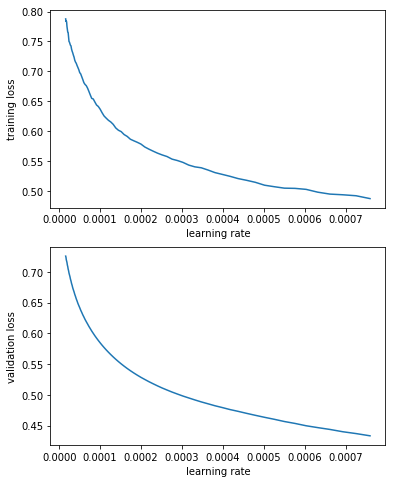

In [40]:
m.lr_find2(start_lr=1e-5, end_lr=1e-3, wds=wd)
m.sched.plot()

In [41]:
m.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(3, 10, 0.95, 0.85), metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                
    0      0.691454   0.539653   0.804878  
    1      0.608836   0.464512   0.832753                
    2      0.562469   0.417556   0.832753                
    3      0.52816    0.394661   0.839721                
    4      0.504784   0.375498   0.843206                
    5      0.484043   0.358654   0.853659                
    6      0.465939   0.342016   0.867596                
    7      0.452849   0.329465   0.874564                
    8      0.438484   0.321535   0.881533                
    9      0.423273   0.310303   0.885017                
    10     0.410991   0.299969   0.885017                
    11     0.398601   0.29194    0.885017                
    12     0.387471   0.28933    0.885017                
    13     0.376894   0.293863   0.878049                
    14     0.367221   0.289421   0.881533                
    15     0.358276   0.285734   0.885017                
    16     0.351246   0.2848

[array([0.28272]), 0.8815331010452961]

In [42]:
from sklearn.metrics import *
def softmax(preds): return [np.exp(pred) / np.exp(pred).sum() for pred in preds]
def rmse(preds): return mean_squared_error(y_test, preds)**.5
def auroc(preds): return roc_auc_score(y_test, preds)
def acc(preds): return accuracy_score(y_test, preds)
def logloss(preds): return log_loss(y_test, preds)

In [43]:
preds = m.predict()
m_preds_pos = np.array([softmax(preds)[i][1] for i in range(len(preds))])
m_clas = m_preds_pos >= 0.5

In [44]:
acc(m_clas), rmse(m_preds_pos), auroc(m_preds_pos), logloss(m_preds_pos)

(0.8815331010452961,
 0.29331535233677564,
 0.9418654631420588,
 0.282717441177413)

In [45]:
(0.8780487804878049,
 0.2876762114723443,
 0.9508918977004083,
 0.27043877222265905)

(0.8780487804878049,
 0.2876762114723443,
 0.9508918977004083,
 0.27043877222265905)